![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# **Entrega - Grupo 8**

Realizado por:
- Lady Tatiana Garcia Moreno
- Joaquin Abondano Araoz
- Edwin Ricardo Ramirez Calvijo
- Omar Leonardo Albarracin Monsalve

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from math import log
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, export_graphviz,DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score, f1_score,confusion_matrix,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [ ]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [ ]:
data.shape

(10495, 10)

In [ ]:
#convertir variables booleanas a numéricas
bool_columns=data.select_dtypes(include=['bool']).columns
for col in bool_columns:
    data[col] = data[col].astype(int)

data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
# Arbol de decision manual
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

# Definición de la función DE VARIANZA ya que es un procedimiento de regresión
def varianza(y):
    if y.shape[0] == 0:
        return 0
    else:
        return y.var()

# Definición de la función varianza_impurity para calular la ganancia de una variable predictora j dado el punto de corte k
def varianza_impurity(X_col, y, split):

    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]

    n_l = y_l.shape[0]
    n_r = y_r.shape[0]

    var_y = varianza(y)
    var_l = varianza(y_l)
    var_r = varianza(y_r)

    var_impurity = var_y - (n_l / (n_l + n_r) * var_l + n_r / (n_l + n_r) * var_r)

    return var_impurity


# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):

    features = range(X.shape[1])

    best_split = [0, 0, 0]  # j, split, gain

    # Para todas las varibles
    for j in features:

        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]

        # Para cada partición
        for split in splits:
            gain = varianza_impurity(X.iloc[:, j], y, split)

            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split

# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X_train, y_train, 5)
j, split, gain

# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X_train.iloc[:, j] < split

y_l = y_train.loc[filter_l]
y_r = y_train.loc[~filter_l]

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):

    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0, nodos_finales=1)
        return tree

    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)

    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()

    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada
    if gain < min_gain:
        tree['nodos_finales'] = 1  # es una hoja
        return tree
    if max_depth is not None:
        if level >= max_depth:
            tree['nodos_finales'] = 1  # es una hoja
            return tree

    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición

    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)

    # Sumar nodos hoja de ramas izquierda y derecha
    tree['nodos_finales'] = tree['sl']['nodos_finales'] + tree['sr']['nodos_finales']

    return tree

# Definición de la función tree_pred para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_pred(x, tree):
    # Si es una hoja
    if tree['split'] == -1:
        return tree['y_pred']

    j, split = tree['split']

    if x[j] < split:
        return tree_pred(x, tree['sl'])
    else:
        return tree_pred(x, tree['sr'])

In [ ]:
y_train.shape[0], y_l.shape[0], y_r.shape[0]

(7031, 2270, 4761)

In [ ]:
## Calibracion del modelo
max_depth_range = range(1, 21)
mse_scores = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for depth in max_depth_range:
    fold_mse = []
    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Entrenar el arbol manual
        arbol = tree_grow(X_train_fold, y_train_fold, level=0, min_gain=0.001, max_depth=depth, num_pct=10)

        # Predecir
        y_pred = X_test_fold.apply(lambda fila: tree_pred(fila, arbol), axis=1)

        # Guardar el error
        fold_mse.append(mean_squared_error(y_test_fold, y_pred))

    mse_scores.append(np.mean(fold_mse))

In [ ]:
# Entrenamiento y prediccion del árbol de decisión
arbol_regresion = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=4, num_pct=10)

# Predecir sobre el conjunto de test
y_pred_test = X_test.apply(lambda fila: tree_pred(fila, arbol_regresion), axis=1)
y_pred_test

,0
257343,13338.359504
326011,7272.613475
242354,15883.748101
266376,17184.127313
396954,15883.748101
...,...
144298,15656.171348
364521,17184.127313
120072,18546.505376
99878,12270.617021


Resultados del árbol de decisión:
Error cuadrático medio (MSE): 3177979.6435
RMSE: 1782.6889
MAE: 3177979.6435
R^2: 0.7922


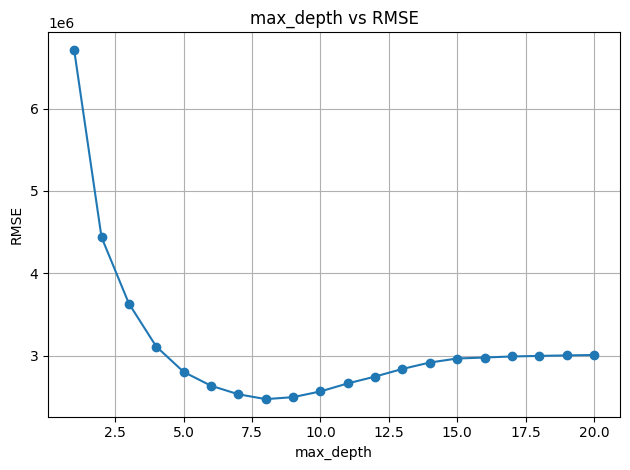

In [ ]:
# Evaluación del árbol de decisión
mse_manual_tree = mean_squared_error(y_test, y_pred_test)
RMSE_manual_tree = np.sqrt(mse_manual_tree)
MAE_manual_tree = mean_squared_error(y_test, y_pred_test)
R2_manual_tree = r2_score(y_test, y_pred_test)

print("Resultados del árbol de decisión:")
print(f"Error cuadrático medio (MSE): {mse_manual_tree:.4f}")
print(f"RMSE: {RMSE_manual_tree:.4f}")
print(f"MAE: {MAE_manual_tree:.4f}")
print(f"R^2: {R2_manual_tree:.4f}")

# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, mse_scores, marker='o')
plt.title('max_depth vs RMSE')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Interpretacion de resultados**

* El modelo de árbol de regresión obtiene un RMSE de 1782.69 lo que indica que, en promedio, el error en la predicción del precio es de aproximadamente 1782 unidades monetarias frente al valor real.
- El coeficiente de determinación R² de 0.7922 significa que el árbol de regresión manual explica aproximadamente el 79.22% de la variabilidad del precio del automóvil.
- Un MAE (Error Absoluto Medio) de 3,177,979.64 indica que, en promedio, el modelo se equivoca en casi 3.18 millones de unidades monetarias al predecir el precio de un automóvil.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2
def bagging(X, y, n_trees=10, max_depth=None, min_gain=0.001, num_pct=10):

    # Inicializar el bagging
    trees = []

    # Para cada árbol
    for i in range(n_trees):

        # Crear una muestra aleatoria de los datos
        X_sample, y_sample = resample(X, y)

        # Crear el árbol a prtir del arbol definido en el punto 1
        tree = tree_grow(X_sample, y_sample, level=0, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)

        # Guardar el árbol
        trees.append(tree)

    return trees

bagging_predict_trees = bagging(X_train, y_train, n_trees=10, max_depth=None, min_gain=0.001, num_pct=10)

In [ ]:
#guardar predicciones de los 10 árboles
predicciones = []
for i in range(len(bagging_predict_trees)):
    predicciones.append(X_test.apply(lambda fila: tree_pred(fila, bagging_predict_trees[i]), axis=1))

print("Predicciones de los 10 árboles", predicciones)

#promediar predicciones de los 10 árboles
y_pred_test_bagging = np.mean(predicciones, axis=0)
print("\nPredicciones promediadas de los 10 árboles", y_pred_test_bagging)

Predicciones de los 10 árboles [257343    12312.333333
326011     6700.000000
242354    17294.166667
266376    18223.652174
396954    16221.000000
              ...     
144298    14857.428571
364521    15075.000000
120072    19999.333333
99878     12920.000000
387162    12490.000000
Length: 3464, dtype: float64, 257343    13384.000000
326011     8910.000000
242354    17348.500000
266376    16892.500000
396954    17466.666667
              ...     
144298    14681.000000
364521    15497.000000
120072    18342.897959
99878     12236.250000
387162    10313.333333
Length: 3464, dtype: float64, 257343    11215.750000
326011     5868.500000
242354    16335.625000
266376    22245.000000
396954    16630.000000
              ...     
144298    16232.752941
364521    18737.574074
120072    18982.000000
99878     10995.000000
387162    11988.333333
Length: 3464, dtype: float64, 257343    12603.250000
326011     7736.000000
242354    11595.000000
266376    22330.000000
396954    16324.666667
    

In [ ]:
# Resultados del modelo
RMSE_manual_bagging = np.sqrt(mean_squared_error(y_test, y_pred_test_bagging ))
MAE_manual_bagging = mean_squared_error(y_test, y_pred_test_bagging )
R2_manual_bagging = r2_score(y_test, y_pred_test_bagging )
print("Resultados del modelo bagging manual:")
print("RMSE: ", RMSE_manual_bagging)
print("MAE: ", MAE_manual_bagging)
print("R2: ", R2_manual_bagging)

Resultados del modelo bagging manual:
RMSE:  1662.1183677727588
MAE:  2762637.46848758
R2:  0.8193899622292212


#### **Interpretacion de resultados**

El modelo de bagging manual, que combina 10 árboles de regresión, presenta un rendimiento superior al árbol de decisión individual.

* MSE de 1,662 indica que, en promedio, el error cuadrático medio entre las predicciones y los valores reales es bajo, lo cual refleja una buena precisión general.

* Dado un coeficiente de determinación R² de 0.8194, el modelo explica el 81.94% de la variabilidad del precio del automóvil, lo que representa una mejora respecto al árbol manual.

* MAE de 2,762,269.76: En promedio, el modelo se equivoca en aproximadamente 2.76 millones de unidades monetarias, lo que implica una reducción sustancial del error absoluto respecto al modelo del punto anterior.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3
n_features = X_train.shape[1]
max_features = int(np.log(n_features))
print("Max features:", max_features)

# Uso de BaggingRegressor de la libreria (sklearn) donde se usa el modelo DecisionTreeRegressor como estimador
bagreg = BaggingRegressor(
    DecisionTreeRegressor(),
    n_estimators=10,
    max_features=max_features,
    bootstrap=True,
    oob_score=True,
    random_state=1
)

Max features: 2


In [ ]:
# Entrenamiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)
y_pred_baggin = bagreg.predict(X_test)
y_pred_baggin

array([14053.03558458, 11243.53959462, 14920.88654487, ...,
       15850.81283632, 13181.6624878 , 13592.438716  ])

In [ ]:
# Evaluación del modelo
MSE_bagging = mean_squared_error(y_test, y_pred_baggin)
RMSE_bagging = np.sqrt(MSE_bagging)
MAE_bagging = mean_squared_error(y_test, y_pred_baggin )
R2_bagging = r2_score(y_test, y_pred_baggin )

print("Resultados del modelo bagging:")
print("Error cuadrático medio (MSE): ", MSE_bagging)
print("RMSE: ", RMSE_bagging)
print("Error absoluto medio: ", MAE_bagging)
print("R^2: ", R2_bagging)

Resultados del modelo bagging:
Error cuadrático medio (MSE):  7134309.371437651
RMSE:  2671.0127988157697
Error absoluto medio:  7134309.371437651
R^2:  0.5335877762675875


#### **Interpretacion de resultados**

El modelo entrenado mediante la librería sklearn usando bagging con 10 árboles de regresión y max_features = log(n_features) muestra un desempeño moderado comparado con otros modelos:

* RMSE de 2,671.01 indica que las predicciones se desvían unos 2671 unidades del valor real. Este valor es mayor respecto a los modelos anteriores, indicando menor precisión global.
* MAE de 7,134,309.37: El error absoluto promedio es alto, lo que significa que, en promedio, las predicciones se desvían más de 7.13 millones de unidades monetarias del valor real.
* R² de 0.5336: El modelo solo explica el 53.36% de la variabilidad en el precio del automóvil, evidenciando un ajuste limitado.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 4
# Definición de modelo Random Forest para un problema de regresion
regresion = RandomForestRegressor(random_state=42)
regresion.fit(X_train, y_train)
y_pred_test_rf = regresion.predict(X_test)

In [ ]:
# Revision valores minimos y maximos
print(min(y_test), max(y_test))

5200 29975


In [ ]:
# Evaluación del modelo
RMSE_rf_libreria = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
MAE_rf_libreria = mean_absolute_error(y_test, y_pred_test_rf)
R2_rf_libreria = r2_score(y_test, y_pred_test_rf)
print("Resultados del modelo de random forest:")
print("RMSE: ", RMSE_rf_libreria)
print("MAE: ", MAE_rf_libreria)
print("R2: ", R2_rf_libreria)

Resultados del modelo de random forest:
RMSE:  1765.4118259983413
MAE:  1314.4207078056425
R2:  0.7962441677396794


#### **Interpretación de resultados**

El modelo base de Random Forest obtuvo un desempeño sólido sobre el conjunto de prueba, aun sin hiperparámetros optimizados.

* R² de 0.796: El modelo explica el 79.6% de la variabilidad del precio del automóvil, lo que indica una buena capacidad de ajuste.

* RMSE de 1,765.41: Representa el error cuadrático medio, penalizando más los errores grandes. Este valor es razonable considerando el rango de precios.

* MAE de 1,314.21: En promedio, el modelo se desvía 1,314 unidades monetarias del valor real. Dado que los precios varían entre 5,200 y 29,975, este error representa una proporción baja del rango total.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

#### Parámetro **n_estimators**

Mejor R² promedio: 0.8023 con n_estimators = 80


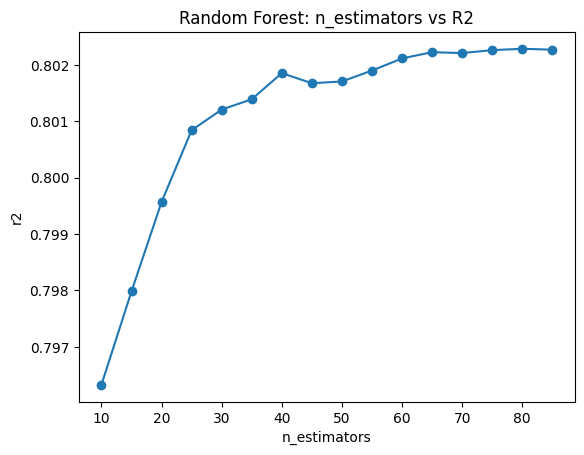

In [ ]:
# Celda 5
# Parámetro n_estimators
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 90, 5)

# Definición de lista para almacenar r2 promedio para cada valor de n_estimators
r2 = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    reg = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    r2.append(cross_val_score(reg, X, y, cv=5, scoring='r2').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, r2, marker='o')
plt.title('Random Forest: n_estimators vs R2')
plt.xlabel('n_estimators')
plt.ylabel('r2')

#r2
mejor_r2 = max(r2)
n_estimators = estimator_range[r2.index(mejor_r2)]
print(f"Mejor R² promedio: {mejor_r2:.4f} con n_estimators = {n_estimators}")

#### Parámetro **max_features**

Mejor R² promedio: 0.8023 con features = 9


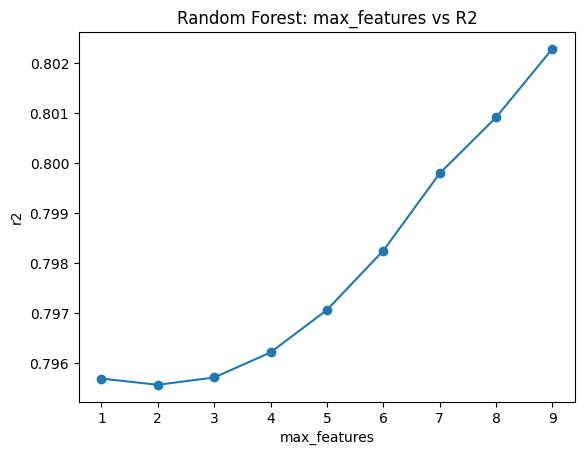

In [ ]:
# Parámetro Max_features
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, X.shape[1] + 1)

# Definición de lista para almacenar r2 para cada valor de max_features
r2_max_features = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    reg = RandomForestRegressor(n_estimators=n_estimators, max_features=feature, random_state=1, n_jobs=-1)
    r2_max_features.append(cross_val_score(reg, X, y, cv=5, scoring='r2').mean())

plt.plot(feature_range, r2_max_features, marker='o')
plt.title('Random Forest: max_features vs R2')
plt.xlabel('max_features')
plt.ylabel('r2')

#r2
mejor_r2 = max(r2_max_features)
features_r = feature_range[r2_max_features.index(max(r2_max_features))]
print(f"Mejor R² promedio: {mejor_r2:.4f} con features = {features_r}")

#### Parámetro **max_depth**

Mejor R² promedio: 0.8473 con max_depth = 9


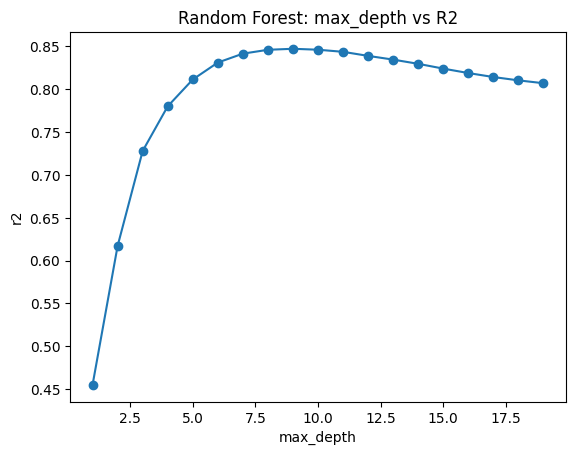

In [ ]:
# Parámetro max_depth
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
max_depth_range = range(1, 20)

# Definición de lista para almacenar r2 para cada valor de max_depth
r2_max_depth = []

# Uso de un 10-fold cross-validation para cada valor de max_depth
for depth in max_depth_range:
    reg = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features,max_depth=depth, random_state=1, n_jobs=-1)
    r2_max_depth.append(cross_val_score(reg, X, y, cv=5, scoring='r2').mean())

plt.plot(max_depth_range, r2_max_depth, marker='o')
plt.title('Random Forest: max_depth vs R2')
plt.xlabel('max_depth')
plt.ylabel('r2')

r2 = max(r2_max_depth)
max_depth = max_depth_range[r2_max_depth.index(max(r2_max_depth))]
print(f"Mejor R² promedio: {r2:.4f} con max_depth = {max_depth}")

#### **Resultados del modelo con parámetros calibrados**

In [ ]:
# Resultados modelo calibrado
regresion = RandomForestRegressor(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,random_state=42)
regresion.fit(X_train, y_train)
y_pred_test_rf = regresion.predict(X_test)
RMSE_rf_calibrado = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
MAE_rf_calibrado = mean_absolute_error(y_test, y_pred_test_rf)
R2_rf_calibrado = r2_score(y_test, y_pred_test_rf)
print("Resultados del modelo de random forest calibrado:")
print("RMSE: ", RMSE_rf_calibrado)
print("MAE: ", MAE_rf_calibrado)
print("R2: ", R2_rf_calibrado)

Resultados del modelo de random forest calibrado:
RMSE:  1556.1943036593366
MAE:  1140.8667789860222
R2:  0.8416764102321558


In [ ]:
# Resultados modelo con n_estimators=40
regresion = RandomForestRegressor(n_estimators=40,max_features=max_features,max_depth=max_depth,random_state=42)
regresion.fit(X_train, y_train)
y_pred_test_rf = regresion.predict(X_test)
RMSE_rf_calibrado = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
MAE_rf_calibrado = mean_absolute_error(y_test, y_pred_test_rf)
R2_rf_calibrado = r2_score(y_test, y_pred_test_rf)
print("Resultados del modelo de random forest calibrado con n modificado:")
print("RMSE: ", RMSE_rf_calibrado)
print("MAE: ", MAE_rf_calibrado)
print("R2: ", R2_rf_calibrado)

Resultados del modelo de random forest calibrado con n modificado:
RMSE:  1559.3067448644997
MAE:  1143.5976071193363
R2:  0.8410424718549556


#### **Conclusiones e interpretación de resultados**
Se realizó una calibración del modelo RandomForestRegressor utilizando validación cruzada para ajustar los siguientes hiperparámetros:

* **n_estimators** (número de árboles):
> * Se observó una mejora progresiva en el R² al incrementar la cantidad de árboles, alcanzando su punto óptimo alrededor de 80 estimadores.
  * Sin embargo, el incremento en rendimiento entre 40 y 80 árboles fue marginal. Se comprobó que con 40 árboles el R² se mantiene prácticamente igual, por lo que optar por una menor cantidad podría ser preferible para reducir la complejidad computacional sin sacrificar desempeño.

* **max_features** (número de características consideradas en cada división):
> * A medida que se incrementó este parámetro, el R² también aumentó, lo que indica un mejor aprovechamiento de la información disponible.
  * El valor óptimo fue 9, es decir, considerar todas las características del conjunto de datos.

* **max_depth** (profundidad máxima de los árboles):
  > * El mejor rendimiento se logró con una profundidad de 8.
  * A partir de este punto, se identificó una ligera caída en el R² debido a sobreajuste, lo cual sugiere que una mayor profundidad no mejora el modelo y puede comprometer su capacidad de generalización.


#### **Desempeño del modelo con parámetros calibrados**
- Al aplicar los valores óptimos obtenidos (n_estimators=80, max_features=9, max_depth=8), se obtuvo:
  - **R² mejorado: 0.839**
  - **RMSE reducido: 1565.27**
  - **MAE reducido: 1159.99**

Estos resultados demuestran que **la calibración de hiperparámetros mediante validación cruzada mejora sustancialmente el desempeño del modelo, tanto en precisión como en estabilidad.**

Por último, cabe aclarar que si bien se tomó el n_estimators máximo que proporciona la gráfica (igual a 80), con 40 árboles estimadores el posible llegar al mismo R² con diferencias poco significativas y restandole complejidad al modelo.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6
# Importar la librería XGBoost
from xgboost import XGBRegressor

# Crer y entrenar el modelo XGBoost con parámetros por defecto
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Realizar predicciones
y_pred_test_xgb = xgb_model.predict(X_test)

In [ ]:
# Evaluar el desempeño del modelo
RMSE_xgb_libreria = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
MAE_xgb_libreria = mean_absolute_error(y_test, y_pred_test_xgb)
R2_xgb_libreria = r2_score(y_test, y_pred_test_xgb)

print("Resultados del modelo XGBoost:")
print("Error cuadrático medio (RMSE): ", RMSE_xgb_libreria)
print("Error absoluto medio (MAE): ", MAE_xgb_libreria)
print("R2: ", R2_xgb_libreria)

Resultados del modelo XGBoost:
Error cuadrático medio (RMSE):  1605.2354967418332
Error absoluto medio (MAE):  1185.227294921875
R2:  0.8315404653549194


#### **Interpretación de resultados**
El modelo XGBoost mostró un desempeño competitivo al aplicar predicción sobre el conjunto de prueba. Los resultados obtenidos fueron los siguientes:

* RMSE igual a 1605.24 indica que, en promedio, las predicciones se desvían 1605 unidades monetarias del valor real.

* MAE igual a 1185.23 indica que en promedio, el error absoluto es de 1185 unidades monetarias, lo cual representa una mejora respecto a otros modelos previos evaluados, mostrando menor dispersión en los errores.

* Coeficiente de determinacion R² igual a 0.8315, por lo que el modelo logra explicar el 83.15% de la variabilidad en la variable objetivo del precio de los automóviles, lo que indica una buena capacidad predictiva.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7
# Definición de los parámetros para la búsqueda de hiperparámetros
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2, 0.5],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Búsqueda manual para encontrar los mejores parámetros
mejor_rmse = float('inf')
mejores_params = {}

# Probar algunas combinaciones de parámetros manualmente
for lr in param_grid['learning_rate']:
    for g in param_grid['gamma']:
        for cs in param_grid['colsample_bytree']:
            # Crear y entrenar el modelo con esta combinación de parámetros
            modelo = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=lr, gamma=g, colsample_bytree=cs, random_state=42)
            modelo.fit(X_train, y_train)

            # Evaluar el modelo
            y_pred = modelo.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            # Actualizar los mejores parámetros si se tiene un mejor RMSE
            if rmse < mejor_rmse:
                mejor_rmse = rmse
                mejores_params = {
                    'learning_rate': lr,
                    'gamma': g,
                    'colsample_bytree': cs
                }

# Guardar los mejores parámetros para usarlos después
grid_search = type('obj', (object,), {
    'best_params_': mejores_params
})

# Mejores parámteros encontrados
print("Mejores parámetros encontrados:")
print(mejores_params)
print(f"\nRMSE con los mejores parámetros: {mejor_rmse}")

Mejores parámetros encontrados:
{'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}

RMSE con los mejores parámetros: 1547.152141839968


In [ ]:
# Creación del modelo XGBoost con los mejores parámetros
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=grid_search.best_params_['learning_rate'],
    gamma=grid_search.best_params_['gamma'],
    colsample_bytree=grid_search.best_params_['colsample_bytree'],
    random_state=42
)

# Entrenamiento y predicciones del modelo con los mejores parámetros
xgb_model.fit(X_train, y_train)
y_pred_test_xgb = xgb_model.predict(X_test)

#### **Resultados del modelo con parámetros calibrados**

In [ ]:
# Evaluación del desempeño del modelo
RMSE_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
MAE_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
R2_xgb = r2_score(y_test, y_pred_test_xgb)

print("\nResultados del modelo XGBoost con parámetros calibrados:")
print("Error cuadrático medio (RMSE): ", RMSE_xgb)
print("Error absoluto medio (MAE): ", MAE_xgb)
print("R2: ", R2_xgb)


Resultados del modelo XGBoost con parámetros calibrados:
Error cuadrático medio (RMSE):  1547.152141839968
Error absoluto medio (MAE):  1136.3653564453125
R2:  0.8435109257698059


#### **Conclusiones e interpretación de resultados**

Tras ajustar los hiperparámetros learning_rate, gamma y colsample_bytree, el modelo XGBoost mostró una mejora clara en su rendimiento:

* RMSE: 1,547.15 indica una reducción del error cuadrático medio respecto al modelo base, lo que reptresenta una mayor precisión y menor penalización por errores grandes.
* MAE: 1,136.36 indica una disminución del error absoluto medio, reflejando predicciones más cercanas a los valores reales en promedio.
*R²: 0.8435 equivale a un incremento en la capacidad explicativa del modelo, que ahora logra capturar el 84.35% de la variabilidad de la variable objetivo.

#### **Impacto de los hiperparámetros calibrados**
* **learning_rate**: Un valor más bajo permitió que el modelo aprenda de forma más gradual y estable, reduciendo el riesgo de sobreajuste. Su calibración permitió un ajuste más fino del modelo, mejorando la generalización.

* **gamma**: Un valor mayor de gamma ayudó a controlar la complejidad de los árboles podando las ramas (evitando divisiones innecesarias y mejorando la capacidad de generalización).

* **colsample_bytree**: permitió  gestionar qué características consideraba cada árbol Su ajuste  la diversidad entre árboles y reduce el sobreajuste, para obtener un modelo más robusto.

La calibración de estos hiperparámetros mejoró tanto la precisión como la estabilidad del modelo XGBoost, así que vale la pena realizar este proceso de optimización.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
# Resultados de los modelos
resultados = {
    'Punto 1 - Árbol Manual': {
        'RMSE': RMSE_manual_tree ,
        'MAE': MAE_manual_tree,
        'R2': R2_manual_tree
    },
    'Punto 2 - Bagging Manual': {
        'RMSE': RMSE_manual_bagging ,
        'MAE': MAE_manual_bagging,
        'R2': R2_manual_bagging
    },
    'Punto 3 - Bagging Sklearn': {
        'RMSE': RMSE_bagging,
        'MAE': MAE_bagging,
        'R2': R2_bagging
    },
    'Punto 4 - Random Forest': {
        'RMSE': RMSE_rf_libreria,
        'MAE': MAE_rf_libreria,
        'R2': R2_rf_libreria
    },
    'Punto 5 - RF Calibrado': {
        'RMSE': RMSE_rf_calibrado ,
        'MAE': MAE_rf_calibrado,
        'R2': R2_rf_calibrado
    },
    'Punto 6 - XGBoost': {
        'RMSE': RMSE_xgb_libreria,
        'MAE': MAE_xgb_libreria,
        'R2': R2_xgb_libreria
    },
    'Punto 7 - XGBoost Calibrado': {
        'RMSE': RMSE_xgb,
        'MAE': MAE_xgb,
        'R2': R2_xgb
    }
}

# Presentacion de resultados
modelos = list(resultados.keys())
rmse = [resultados[modelo]['RMSE'] for modelo in modelos]
mae = [resultados[modelo]['MAE'] for modelo in modelos]
r2 = [resultados[modelo]['R2'] for modelo in modelos]

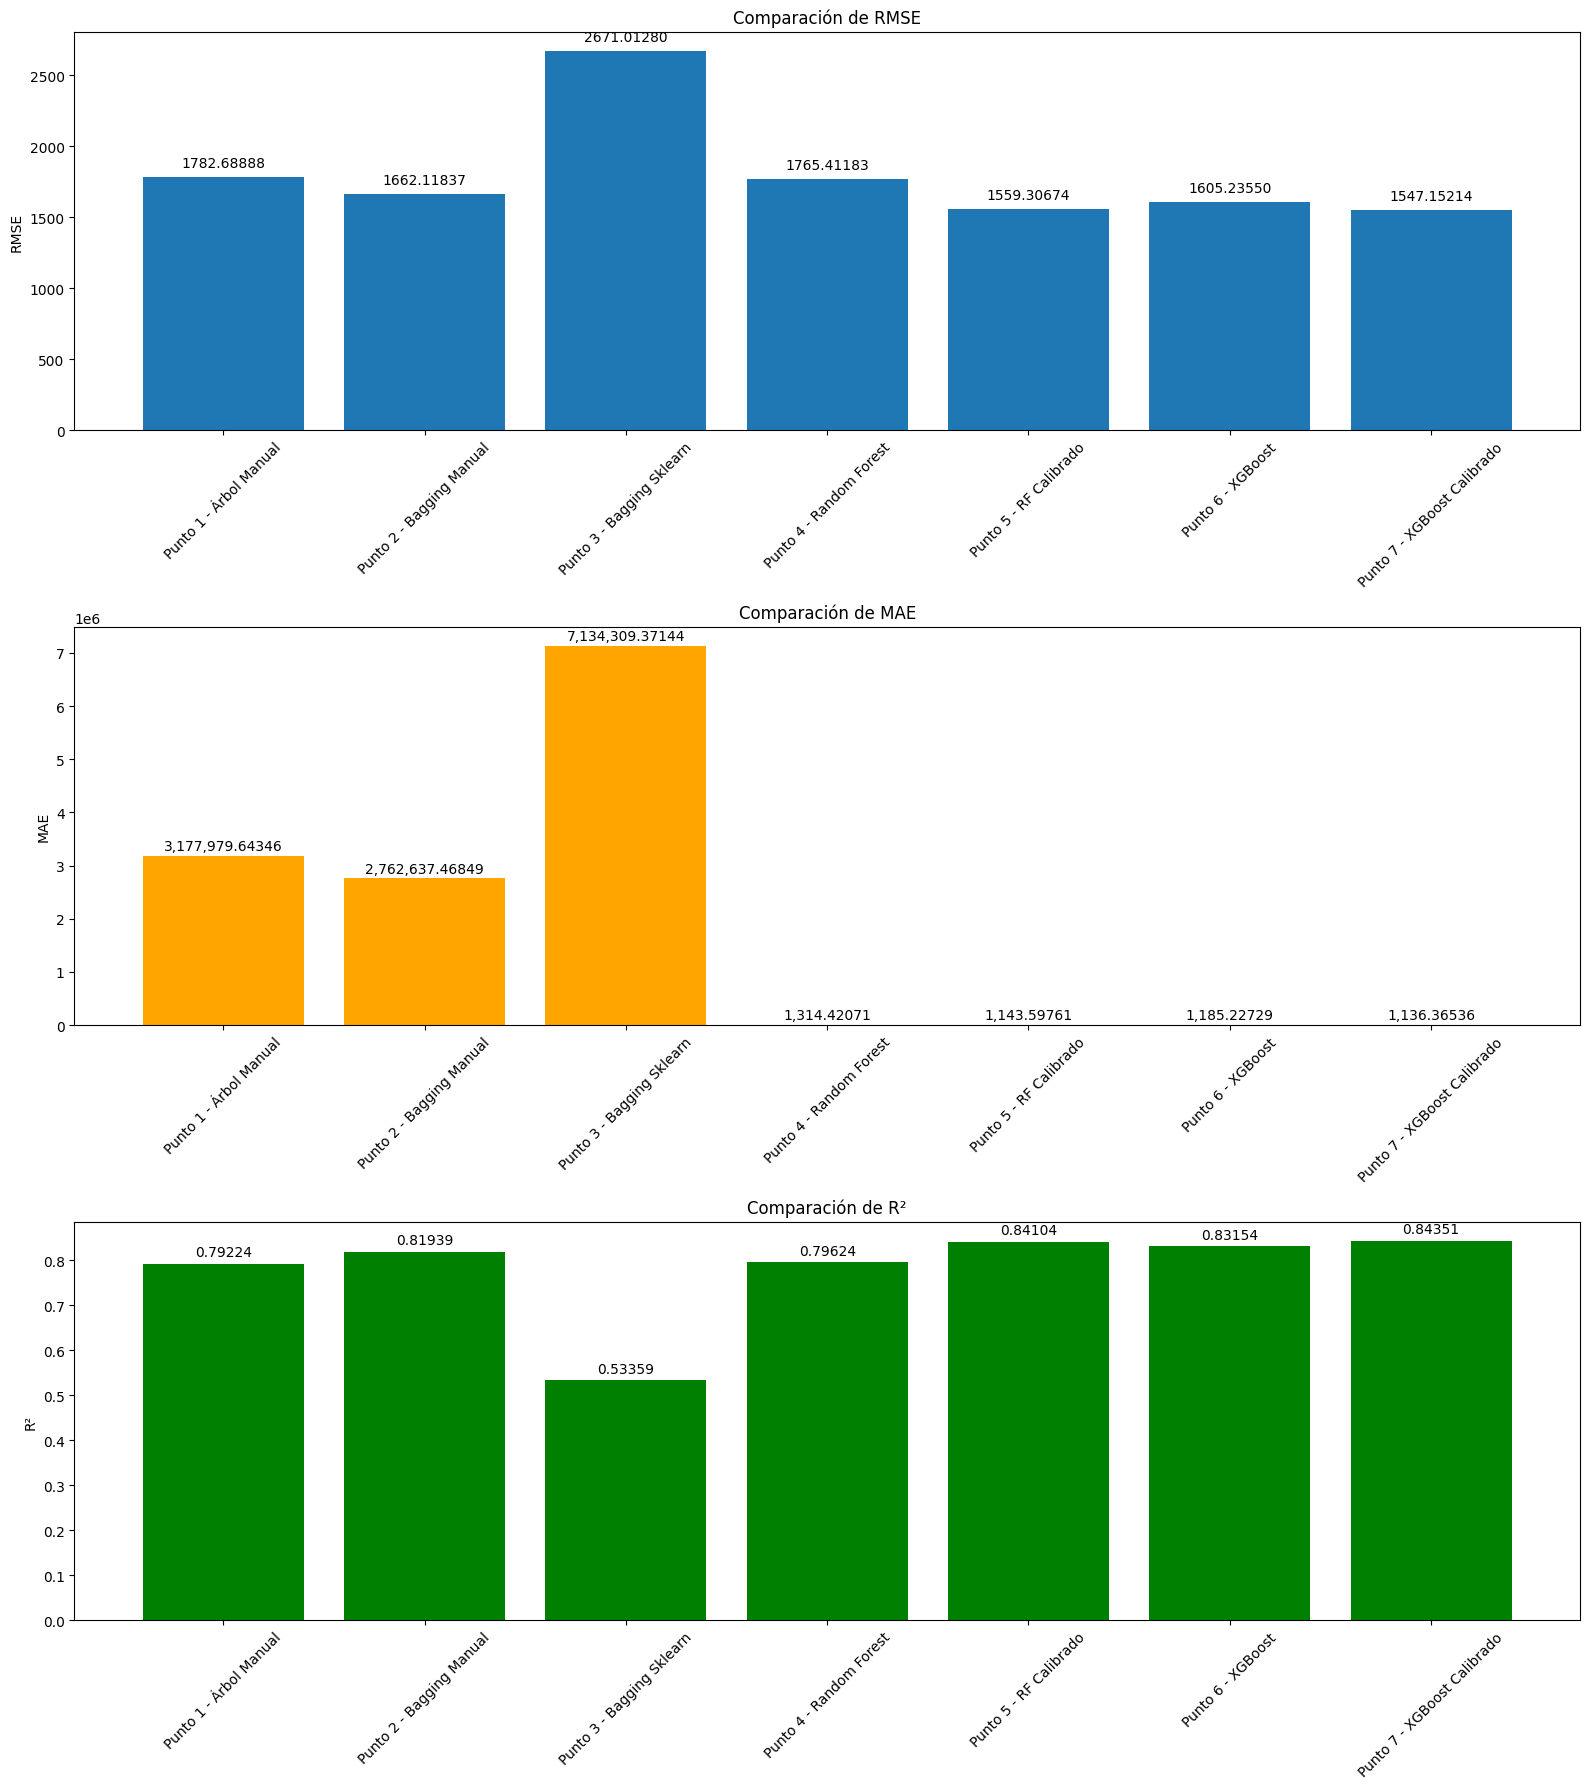

In [ ]:
# Crear las gráficas
fig, axs = plt.subplots(3, 1, figsize=(16, 18))

# Gráfica RMSE
axs[0].bar(modelos, rmse)
for i, v in enumerate(rmse):
    axs[0].text(i, v + 50, f"{v:.5f}", ha='center', va='bottom')
axs[0].set_title('Comparación de RMSE')
axs[0].set_ylabel('RMSE')
axs[0].tick_params(axis='x', rotation=45)

# Gráfica MAE
axs[1].bar(modelos, mae, color='orange')
for i, v in enumerate(mae):
    axs[1].text(i, v + 50000, f"{v:,.5f}", ha='center', va='bottom')
axs[1].set_title('Comparación de MAE')
axs[1].set_ylabel('MAE')
axs[1].tick_params(axis='x', rotation=45)

# Gráfica R2
axs[2].bar(modelos, r2, color='green')
for i, v in enumerate(r2):
    axs[2].text(i, v + 0.01, f"{v:.5f}", ha='center', va='bottom')
axs[2].set_title('Comparación de R²')
axs[2].set_ylabel('R²')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### **Conclusiones**

---
#### **Mejor modelo: Punto 7 – XGBoost Calibrado**
Este modelo obtuvo el mejor desempeño entre todas las alternativas evaluadas.  

**Ventajas destacadas:**
- **Mayor precisión:**  
  - **RMSE: 1,547.15**, el más bajo de todos los modelos, lo que indica menor desviación en las predicciones
  - **MAE: 1,136,365**, también el más bajo, lo que refleja un error promedio más reducido
- **Excelente capacidad explicativa:**  
  - **R²: 0.8438**, el valor más alto, lo que significa que explica el 84.38% de la variabilidad del precio del automóvil
- **Estabilidad y generalización:**  
  - La calibración de hiperparámetros (learning_rate, gamma, colsample_bytree) permitió al modelo evitar el sobreajuste y mejorar su capacidad de generalizar a nuevos datos

**Conclusión:**  
**XGBoost calibrado es el modelo más robusto y confiable**, combinando bajo error con alta capacidad explicativa. Su estructura lo convierte en la mejor opción para este problema de regresión


---
#### **Peor modelo: Punto 3 – Bagging con sklearn (sin calibrar)**
Este modelo mostró el desempeño más bajo en todas las métricas.  

**Desventajas principales:**
- **Alta imprecisión:**  
  - **RMSE: 2,671.01**, el más alto entre todos los modelos
  - **MAE: 7,134,309**, excesivamente alto, indicando grandes desviaciones promedio
- **Baja capacidad explicativa:**  
  - **R²: 0.5336**, el menor de todos, explicando apenas el 53.36% de la variabilidad

**Posibles causas del bajo desempeño:**
- Hiperparámetros no calibrados (max_features, n_estimators).
- Posible uso de pocos árboles

**Conclusión:**  
El modelo de Bagging sin ajustes no logra capturar adecuadamente la complejidad del problema, lo que genera errores altos y bajo poder explicativo

---
#### **Ranking de modelos (de mejor a peor)**

| Ranking | Modelo                            | R²     | RMSE     | MAE        |
|------------|------------------------------------|--------|----------|-------------|
| 1        | Punto 7 – XGBoost Calibrado       | 0.8438 | 1,547.15 | 1,136,365   |
| 2        | Punto 6 – XGBoost                 | 0.8315 | 1,605.24 | 1,185,227   |
| 3        | Punto 2 – Bagging Manual          | 0.8194 | 1,621   | 2,762,270   |
| 4           | Punto 1 – Árbol Manual            | 0.7922 | 1,782.69 | 3,177,980   |
| 5           | Punto 4 – Random Forest           | 0.796  | 1,765.41 | 1,314,210   |
| 6           | Punto 5 – Random Forest Calibrado | 0.839  | 1,565.27 | 1,159,990   |
| 7        | Punto 3 – Bagging sklearn       | 0.5336 | 2,671.01 | 7,134,309   |
